In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, train_test_split, cross_val_score
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
                             classification_report, accuracy_score,
                             precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.feature_selection import SelectKBest, chi2
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
# Carregar o dataset
df = pd.read_csv("/content/drive/MyDrive/base_tjsp.csv")

# Estrutura do dataset
shape_data = df.shape
print(f"O dataset possui {shape_data[0]} linhas e {shape_data[1]} atributos.")
df.head(3)

O dataset possui 300 linhas e 17 atributos.


,cdacordao,termos_frequentes,processo,classe,assunto,relator,comarca,orgao_julgador,data_julgamento,data_publicacao,ementa,julgado,topic,classificacao_level0,classificacao_level1,classificacao_level2,observacoes
0,1170177,runs faces,90062675920058253312,Habeas Corpus,Furto,Eduardo Pereira,Comarca nâo informada,12ª Câmara de Direito Criminal,NaN,NaN,"HABEAS CORPUS n"" 880736/8\r\nComarca: SÃO PAUL...",?v\r\n\r\n PODER ...,1,0,NaN,NaN,Não é crime cibernético.
1,2591479,hosting dados providers,90520622020078256138,Agravo de Instrumento,DOMÍNIO DE MARCA VIRTUAL,Egidio Giacoia,Ribeirão Preto,3ª Câmara de Direito Privado,2008-04-29,NaN,"AGRAVO DE INSTRUMENTO - Obrigação de Fazer - ""...",PODER JUDICIÁRIO\r\n ...,3,1,C,C4,Difamação através de redes sociais
2,4854160,bancos cheques dados dozes sites trojans,91175363520078266378,Apelação Cível,Cartão de Crédito,Ricardo Negrão,São Vicente,19ª Câmara de Direito Privado,2010-10-26,NaN,DANO MORAL - Banco de dados - Inclusão indevid...,3\r\n°l ...,2,0,NaN,NaN,Não é crime cibernético.


In [5]:
# Proporção da classificação 'Crime Cibernético', 'Outros'
proporcao = df['classificacao_level0'].value_counts(normalize=True)

for classe, prop in proporcao.items():
    print(f"Classe {classe}: {prop*100:.2f}%")

Classe 1: 55.33%
Classe 0: 44.67%


In [7]:
# Juntar texto da ementa e do acórdão
df_modelo = df.copy()
df_modelo["texto_completo"] = df["ementa"] + " " + df["julgado"]

In [8]:
# Adicionar uma coluna de ano julgamento
df_modelo['ano_julgamento'] = df_modelo['data_julgamento'].str.extract(r'(\d{4})')

# Adicionar uma coluna de período com base no ano julgamento
conditions = [
    df_modelo['ano_julgamento'].isin(['2010', '2011', '2012', '2013', '2014', '2015']),
    df_modelo['ano_julgamento'].isin(['2016', '2017', '2018', '2019', '2020']),
    df_modelo['ano_julgamento'].isin(['2021', '2022', '2023', '2024'])
]
choices = ['2010-2015', '2016-2020', 'após 2020']
df_modelo['periodo'] = np.select(conditions, choices, default='anterior a 2010')

In [10]:
lemmatizer = nltk.stem.WordNetLemmatizer()
stopwords_pt = set(stopwords.words('portuguese'))

# Criar listas com nomes dos relatores, cidades e órgãos julgadores para serem removidos do texto
nome_relator = "|".join(df_modelo['relator'].dropna().str.lower().unique())
nome_cidade = "|".join(df_modelo['comarca'].dropna().str.lower().unique())
nome_orgao = "|".join(df_modelo['orgao_julgador'].dropna().str.lower().unique())


# Pré-processar texto completo
def preprocess_text(text):
    if pd.isnull(text):
        return ""

    text = text.lower()
    text = re.sub(r".*?(acórdão)", " ", text)

    # Remover cabeçalhos, assinaturas, nomes, datas, e outros padrões
    substitutions = [
        r"poder judiciário\s+tribunal de justiça (do estado de são paulo|do estado)?",
        r"tribunal de justiça\s+poder judiciário",
        r"assinatura eletrônica",
        r"\n",
        nome_relator,
        nome_cidade,
        nome_orgao,
        r"\b\d{1,2}[-/.]\d{1,2}[-/.]\d{2,4}\b",
        r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.(com|com\.br)\b",
        r"https?://\S+|www\.\S+",
        r"[ºª°]",
        r"[0-9]",
        r"\b[A-Za-z]\b",
    ]

    for pattern in substitutions:
        text = re.sub(pattern, " ", text)

    # Remover pontuação e espaços extras
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenizar
    text = word_tokenize(text)

    # Remover stopwords
    text = [word for word in text if word not in stopwords_pt]

    # Lemantizar
    text = [lemmatizer.lemmatize(word) for word in text]

    return text

# Aplicar pré-processamento
df_modelo['texto_tratado'] = df_modelo['texto_completo'].apply(preprocess_text)

In [ ]:
# Inicializar tokenizer e modelo BERTimbau (português)
model_name = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def gerar_bertimbau_embeddings(textos, batch_size=16):
    embeddings = []
    for i in range(0, len(textos), batch_size):
        batch_textos = textos[i:i+batch_size]
        # Tokenizar com truncation, padding automático e max length
        inputs = tokenizer(batch_textos, return_tensors='pt', padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        # Média das embeddings dos tokens da última camada
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings)

# Supondo que df_modelo['texto_tratado'] seja uma coluna de listas de tokens,
# primeiro converta para texto:
textos = [' '.join(tokens) for tokens in df_modelo['texto_tratado']]

X_bert = gerar_bertimbau_embeddings(textos)

In [16]:
# One-Hot Encoding nas colunas categóricas
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat = encoder.fit_transform(df_modelo[['classe', 'assunto', 'topic', 'periodo']])

# Combinar BERT embeddings (denso) com variáveis categóricas (esparsas)
from scipy.sparse import csr_matrix
X_bert_sparse = csr_matrix(X_bert)  # converter para sparse para poder combinar
X_combined = hstack([X_bert_sparse, X_cat])

# Definir features e target
X = X_combined
y = df_modelo['classificacao_level0']

# Informações
print(f"Shape dos dados combinados: {X_combined.shape}")


Shape dos dados combinados: (300, 829)


Modelos

In [ ]:
# Validação cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

modelos = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    #'NaiveBayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (Linear)': SVC(kernel='linear', probability=True, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}

resultados = []

for nome, modelo in modelos.items():
    pipe = Pipeline([
        ('clf', modelo)
    ])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='f1')
    media = np.mean(scores)
    std = np.std(scores)

    resultados.append({
        'nome': nome,
        'f1_mean': media,
        'f1_std': std
    })

    print(f"{nome} → F1 médio: {media:.4f} | Desvio padrão: {std:.4f}")

LogisticRegression → F1 médio: 0.7994 | Desvio padrão: 0.1067
Random Forest → F1 médio: 0.7704 | Desvio padrão: 0.1189
SVM (Linear) → F1 médio: 0.7748 | Desvio padrão: 0.0756


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:42:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:42:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:42:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:42:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:42:22] WARNING: /w

XGBoost → F1 médio: 0.7856 | Desvio padrão: 0.0902


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM → F1 médio: 0.8044 | Desvio padrão: 0.0924


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Regressão Logística


Avaliação Final - Regressão Logistica (sem seleção de atributos):
              precision    recall  f1-score   support

           0       0.74      0.85      0.79        27
           1       0.86      0.76      0.81        33

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.81      0.80      0.80        60

Accuracy: 0.8
Precision: 0.8620689655172413
Recall: 0.7575757575757576
F1 Score: 0.8064516129032258
ROC AUC Score: 0.8406285072951739


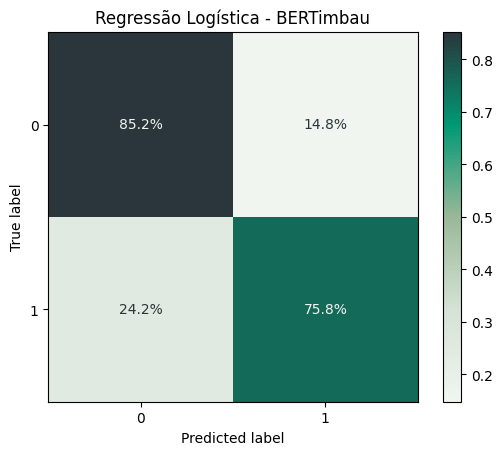

In [19]:
# Divisão em treino e teste final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Treinamento do modelo final com todas as features
modelo_final = LogisticRegression(max_iter=1000, random_state=42)
modelo_final.fit(X_train_final, y_train_final)

# Previsões
y_pred_final = modelo_final.predict(X_test_final)
y_prob_final = modelo_final.predict_proba(X_test_final)[:, 1]

# Métricas
print("\nAvaliação Final - Regressão Logistica (sem seleção de atributos):")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_final.classes_)
disp.plot(cmap=cmap, values_format=".1%")
plt.title("Regressão Logística - BERTimbau")
plt.show()

Floresta Aleatória


Avaliação Final - Random Forest (sem seleção de atributos):
              precision    recall  f1-score   support

           0       0.66      0.70      0.68        27
           1       0.74      0.70      0.72        33

    accuracy                           0.70        60
   macro avg       0.70      0.70      0.70        60
weighted avg       0.70      0.70      0.70        60

Accuracy: 0.7
Precision: 0.7419354838709677
Recall: 0.696969696969697
F1 Score: 0.71875
ROC AUC Score: 0.7480359147025815


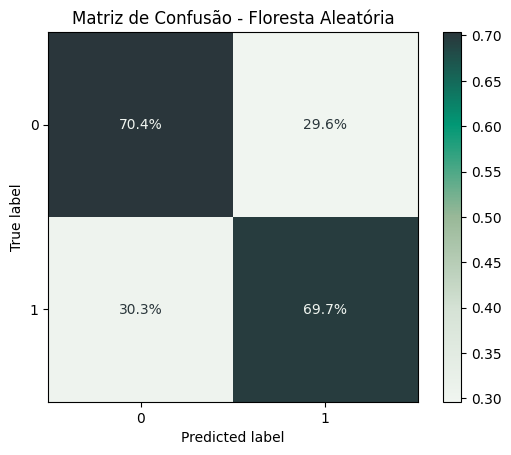

In [20]:
# Separar os dados em treino e teste final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Treinar modelo final
modelo_final = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_final.fit(X_train_final, y_train_final)

# Previsões
y_pred_final = modelo_final.predict(X_test_final)
y_prob_final = modelo_final.predict_proba(X_test_final)[:, 1]

# Avaliação
print("\nAvaliação Final - Random Forest (sem seleção de atributos):")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_final.classes_)
disp.plot(cmap=cmap, values_format=".1%")
plt.title("Matriz de Confusão - Floresta Aleatória")
plt.show()


Naive Bayes


Avaliação Final - Naive Bayes (sem seleção de atributos):
              precision    recall  f1-score   support

           0       0.67      0.74      0.70        27
           1       0.77      0.70      0.73        33

    accuracy                           0.72        60
   macro avg       0.72      0.72      0.72        60
weighted avg       0.72      0.72      0.72        60

Accuracy: 0.7166666666666667
Precision: 0.7666666666666667
Recall: 0.696969696969697
F1 Score: 0.7301587301587301
ROC AUC Score: 0.7109988776655445


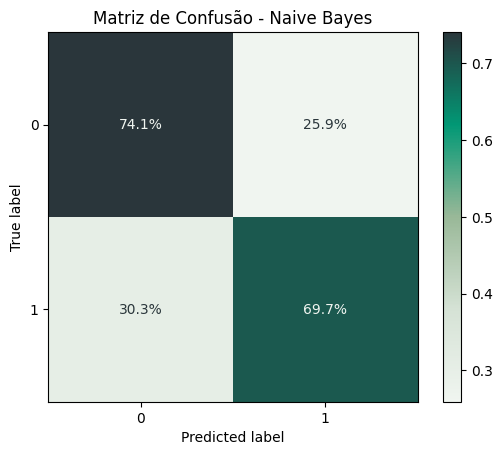

In [21]:
# Divisão em treino e teste final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Treinamento do modelo final com todas as features
modelo_final = GaussianNB()
modelo_final.fit(X_train_final.toarray(), y_train_final)

# Previsões
y_pred_final = modelo_final.predict(X_test_final.toarray())
y_prob_final = modelo_final.predict_proba(X_test_final.toarray())[:, 1]

# Métricas
print("\nAvaliação Final - Naive Bayes (sem seleção de atributos):")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_final.classes_)
disp.plot(cmap=cmap, values_format=".1%")
plt.title("Matriz de Confusão - Naive Bayes")
plt.show()

SVM


Avaliação Final - SVM (sem seleção de atributos):
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        27
           1       0.80      0.73      0.76        33

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.76      0.75      0.75        60

Accuracy: 0.75
Precision: 0.8
Recall: 0.7272727272727273
F1 Score: 0.7619047619047619
ROC AUC Score: 0.8327721661054994


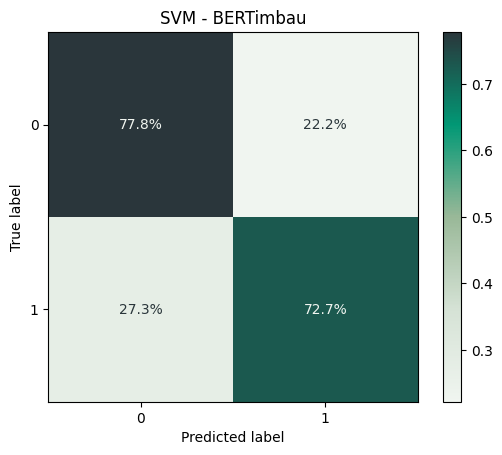

In [22]:
# Divisão em treino e teste final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Treinamento do modelo final com todas as features
modelo_final = SVC(kernel='linear', probability=True, random_state=42)
modelo_final.fit(X_train_final, y_train_final)

# Previsões
y_pred_final = modelo_final.predict(X_test_final)
y_prob_final = modelo_final.predict_proba(X_test_final)[:, 1]

# Métricas
print("\nAvaliação Final - SVM (sem seleção de atributos):")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_final.classes_)
disp.plot(cmap=cmap, values_format=".1%")
plt.title("SVM - BERTimbau")
plt.show()

XGBoost

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:42:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Avaliação Final - XGBoost (sem seleção de atributos):
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        27
           1       0.76      0.76      0.76        33

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.73      0.73      0.73        60

Accuracy: 0.7333333333333333
Precision: 0.7575757575757576
Recall: 0.7575757575757576
F1 Score: 0.7575757575757576
ROC AUC Score: 0.7912457912457913


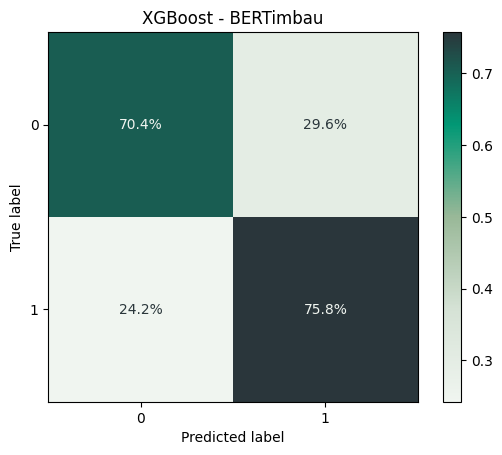

In [23]:
# Divisão em treino e teste final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Treinamento do modelo final com todas as features
modelo_final = XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=42)
modelo_final.fit(X_train_final, y_train_final)

# Previsões
y_pred_final = modelo_final.predict(X_test_final)
y_prob_final = modelo_final.predict_proba(X_test_final)[:, 1]

# Métricas
print("\nAvaliação Final - XGBoost (sem seleção de atributos):")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_final.classes_)
disp.plot(cmap=cmap, values_format=".1%")
plt.title("XGBoost - BERTimbau")
plt.show()

LightGBM


Avaliação Final - LGBM (sem seleção de atributos):
              precision    recall  f1-score   support

           0       0.70      0.70      0.70        27
           1       0.76      0.76      0.76        33

    accuracy                           0.73        60
   macro avg       0.73      0.73      0.73        60
weighted avg       0.73      0.73      0.73        60

Accuracy: 0.7333333333333333
Precision: 0.7575757575757576
Recall: 0.7575757575757576
F1 Score: 0.7575757575757576
ROC AUC Score: 0.7800224466891134


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


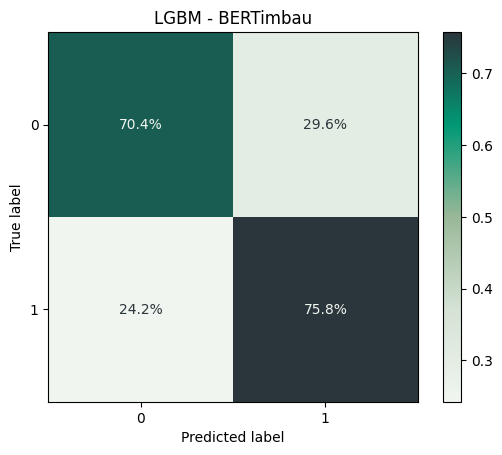

In [24]:
# Divisão em treino e teste final
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Treinamento do modelo final com todas as features
modelo_final = lgb.LGBMClassifier(random_state=42, verbose=-1)
modelo_final.fit(X_train_final, y_train_final)

# Previsões
y_pred_final = modelo_final.predict(X_test_final)
y_prob_final = modelo_final.predict_proba(X_test_final)[:, 1]

# Métricas
print("\nAvaliação Final - LGBM (sem seleção de atributos):")
print(classification_report(y_test_final, y_pred_final))
print("Accuracy:", accuracy_score(y_test_final, y_pred_final))
print("Precision:", precision_score(y_test_final, y_pred_final))
print("Recall:", recall_score(y_test_final, y_pred_final))
print("F1 Score:", f1_score(y_test_final, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y_test_final, y_prob_final))

# Matriz de confusão
cm = confusion_matrix(y_test_final, y_pred_final, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo_final.classes_)
disp.plot(cmap=cmap, values_format=".1%")
plt.title("LGBM - BERTimbau")
plt.show()